# Introduction to Text Analysis

**Garren Gaut with contributions from Avishek Kumar**

---


## Table of Contents
 - [Data Source](#Data-Source:-Reddit-Comments-from-May-2015-in-JSON-format)
 - [Preprocess](#Preprocess-the-data)
 - [Supervised Learning](#Supervised-Learning:-Identify-the-Subreddit-Section)
 - [Unsupervised Learning](#Topic-Modeling:-Unsupervised-Learning )
 
---

## Introduction


Text Analysis is used for summarizing or extracting useful information from large amounts of  unstructured text. Text analysis encompases a large array of tasks: 

<img src="figs/nlp_tasks.png">

<!--
Text Analysis can help with the following tasks:

* **Searches and information retrieval**: Help find relevant information in large databases such as a systematic literature review. 

* **Clustering**: Text clustering is organizing text documents into groups that share properties such as theme, author, or type of document. 

* **Dimensionality Reduction**: Techniques such as topic modeling can summarize a large corpus of text by representing documents as mixtures of topics. 

* **Text Summarization**: Create category-sensitive text summaries of a large corpus of text. 

* **Machine Translation**: Translate from one language to another. 

In this tutorial we are going to analyze reddit posts from May 2015 in order to classify which subreddit a post origniated from and also do topic modeling to categorize posts. 
-->
---


 ## Demos 

 - [Stanford NLP](http://nlp.stanford.edu:8080/corenlp/process)    
 - [Illinois Cognitive Computation Group](http://cogcomp.cs.illinois.edu/page/demos/)    
 - [Event Search](http://eventregistry.org/searchEvents)    
 
 ---


## Glossary of Terms

* **Tokenize**: Tokenization is the process by which text is sepearated into meaningful terms or phrases. For instance, separating sentences using punctuation. 

* **Stemming**: Stemming is a type of text normalization where words that have different forms but their essential meaning are normalized to the original dictionary form of a word. For example "go," "went," and "goes" all stem from the lemma "go."

* **TFIDF**: TFIDF (Term frequency-inverse document frequency) is an example of feature enginnering where the most important words are extracted by taking account their frequency in documents and the entire corpus of documents as a whole.

* **Topic Modeling**: Topic modeling is an unsupervised learning method where groups of co-occuring words are clustered into topics. Typically, the words in a a cluster should be related and make sense (e.g, boat, ship, captain). Individual documents will then fall into multiple topics. 

* **LDA**: LDA (latent Dirichlet allocation) is a type of probabilistic model commonly used for topic modelling. 

* **Stop Words**: Stop words are words that have little semantic meaning like prepositions, articles and common nouns. They can often be ingnored. 

* **Document Classification**: Predicting which class label belongs to a document. 

* **Word (type) vs word token**: In text analysis, *word (type)* refers to a unique set of characters. A *word token* is any occurance of a *word (type)*. For example, the sentence 'Oh boy, that boy is impressive!' contains 6 *word tokens*, but only 5 *word (types)*.   

 ---

### Import packages and utility functions 

In [193]:
%pylab inline 
import nltk
import ujson
import re
import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering, spectral_clustering
from collections import Counter, OrderedDict
from nltk.corpus import stopwords
from nltk import SnowballStemmer

nltk.download('stopwords') # download the latest stopwords

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Garren/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def load_reddit(fname, ls_subreddits=[], MIN_CHAR=30):
    """
    Loads Reddit Comments from a json file based on 
    whether they are in the selected subreddits and 
    have more than the MIN_CHARACTERS
    
    Parameters
    ----------
    fname: str
        filename
    ls_subreddits: ls[str]
        list of subreddits to select from 
    MIN_CHAR: int
        minimum number of characters necessary to select
        a comment
        
    Returns
    -------
    corpus: ls[str]
        list of selected reddit comments
    subreddit_id: array[int]
        np.array of indices that match with the ls_subreddit
        index 
    """
    corpus = []
    subreddit_id = []
    with open(fname, 'r') as infile:
        for line in infile:
            dict_reddit_post =  ujson.loads(line)
            subreddit = dict_reddit_post['subreddit']
            n_characters = len( dict_reddit_post['body'] )
            
            if ls_subreddits: # check that the list is not empty
                in_ls_subreddits = subreddit in ls_subreddits
            else:
                in_ls_subreddits = True
            
            grter_than_min = n_characters > MIN_CHAR
            
            if ( grter_than_min and in_ls_subreddits ):
                corpus.append(dict_reddit_post['body'])
                subreddit_id.append(subreddit)
                
    return np.array(corpus), np.array(subreddit_id)

In [30]:
def plot_roc(y_true, y_score):
    """
    Plots the precision and recall as a function 
    of the percent of data for which we calculate 
    precision and recall 
    
    Parameters
    ----------
    ytrue: 

    yprob_: 

    model_name: 
    
    """
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = roc_auc_score( y_true, y_score)
    
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

## Load and Preprocess Data

### Data Source: Reddit Comments from May 2015 in JSON format

For the superivised learning portion of the tutorial we will being attempting to classify whether reddit comments have come from /r/SucideWatch or /r/depression. These two subreddits are somewhat similiar so it poses a non-trivial challenge for a classifier.

In [5]:
# grab data from the following subreddits
ls_subreddits = ['SuicideWatch', 'depression']
[corpus, subreddit_id] = load_reddit('./data/RC_2015-05.json', ls_subreddits, MIN_CHAR=30)

# count the number of comments in each subreddit 
Counter(subreddit_id)

Counter({'SuicideWatch': 12609, 'depression': 24683})

## Preprocess the data

In order to quantify our text, we will have to remove characters that aren't parts of words. 

In [37]:
# create an expression to remove from data 
RE_PREPROCESS = re.compile(r""" \W + # one or more nonword characters
                                |    # the or operator
                                \d+  # the decimal point""", re.VERBOSE)

# remove anything matching RE_PREPROCESS and make lowercase 
processed_corpus = np.array( [ re.sub(RE_PREPROCESS, ' ', comment).lower() for comment in corpus] )
#processed_corpus2 = np.array( [ re.sub(RE_PREPROCESS2, ' ', comment).lower() for comment in corpus] )

# check out original and preprocessed data 
num_comment_to_view = 0
for i in range(0, num_comment_to_view):
    print("Original: subreddit: {}, comment: {}".format(subreddit_id[i],corpus[i]))
    print()
    print("Processed: subreddit: {}, comment: {}".format(subreddit_id[i],processed_corpus[i]))
    
    print('\n\n')



### Activity 1: 
**10 mins**

Write your own preprocessing routine that removes **only happy and sad emojis** from each comment in the corpus. Write a loop that prints comments `[1788, 2360, 9679, 18096]` to check that your choice of regular expression preprocess the text as you intended. [Python regular expression documentation](https://docs.python.org/2/library/re.html) will be helpful. 


In [36]:
# ANSWER
comments_to_check = [1788, 2360, 9679, 18096]

RE_PREPROCESS_EMOJI = re.compile(r'(:\))|(:\()')

emojiless_corpus = np.array( [ re.sub(RE_PREPROCESS_EMOJI, ' ', comment) for comment in corpus] )
for i in comments_to_check:
    print("\nComment {}:\n \n{}\n{}".format(i, corpus[i], emojiless_corpus[i]))
        


Comment 1788:
 
:/ this loneliness must be so hard then...I do hope you'll think about calling a friend if these feelings get stronger.  I don't want you to be scared. 
:/ this loneliness must be so hard then...I do hope you'll think about calling a friend if these feelings get stronger.  I don't want you to be scared. 

Comment 2360:
 
:( You need to call someone...I had a panic attack right before I swallowed around 10 pills and saw the fucking police coming up the steps for me...I know that feeling.

You can do serious damage and please don't take anymore pills. I care about you. :)

~LG
  You need to call someone...I had a panic attack right before I swallowed around 10 pills and saw the fucking police coming up the steps for me...I know that feeling.

You can do serious damage and please don't take anymore pills. I care about you.  

~LG

Comment 9679:
 
:| seriously? I wanted to get into building this pc as a **hobby**, something to get myself interested in. I already go for jog

# Supervised Learning: Identify the Subreddit Section

In this section we are going to train a classifier to properly tag the original subreddit the comment appeared. First we split our data into a testing and training set using the first 80% of the data as the training set and the remaining 20% as the testing set. 

### Create Training/Test Splits

In [221]:
#split the data into training and testing sets. 
#refactor this in the test train-split
train_set_size = int(0.8*len(subreddit_id))
train_idx = np.arange(0,train_set_size)
test_idx = np.arange(train_set_size, len(subreddit_id))

train_subreddit_id = subreddit_id[train_idx]
train_corpus = processed_corpus[train_idx]

test_subreddit_id = subreddit_id[test_idx]
test_processed_corpus = processed_corpus[test_idx]
test_corpus = corpus[test_idx]

print('Training Labels', Counter(subreddit_id[train_idx]))
print('Testing Labels', Counter((subreddit_id[test_idx])))

Training Labels Counter({'depression': 19382, 'SuicideWatch': 10451})
Testing Labels Counter({'depression': 5301, 'SuicideWatch': 2158})


# Tokenize and stem to create features

Now that we have the data and we have done a bit of preprocessing, we want to create features. We quantify words as **one-hot encodings** and create document word counts by summing encodings over words in a documents. Scikit-learn as a [CountVectorizer method](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) that makes this step simple. 

We first create a vectorizer object that stores the frequency of words in each of the documents in a **document-term count matrix**. We will discard very high and low frequency words. For example, the words *the* or *for* may appear often throughout a corpus but contain very little semantic information. Conversely a document may contain obscure words that do not occur anywhere in else in the corpus which could cause models to overfit. These cases are managed by setting a threshold for the Min and Max Document Frequency(DF).  

In [39]:
# parameters for vectorizer 
ANALYZER = "word" # unit of features are single words rather then phrases of words 
STRIP_ACCENTS = 'unicode' 
TOKENIZER = None
NGRAM_RANGE = (0,2) # Range for n-grams 
MIN_DF = 0.01 # Exclude words that are contained in less that x percent of documents 
MAX_DF = 0.8  # Exclude words that are contained in more than x percent of documents 

vectorizer = CountVectorizer(analyzer=ANALYZER,
                            tokenizer=None, # alternatively tokenize_and_stem but it will be slower 
                            ngram_range=NGRAM_RANGE,
                            stop_words = stopwords.words('english'),
                            strip_accents=STRIP_ACCENTS,
                            min_df = MIN_DF,
                            max_df = MAX_DF)
                            # could add 'token_pattern' argument to specify what denotes a token 

**TFIDF (Term Frequency Inverse Document Frequency)** transforms a count matrix--what we created above--into a TFIDF represenation. This is done by reweighting words that occur throughout the entire corpus to a lower weight due to empirically being found to be less discriminative. 


In [40]:
NORM = None #turn on normalization flag
SMOOTH_IDF = True #prvents division by zero errors
SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
USE_IDF = True #flag to control whether to use TFIDF

transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)

In [41]:
#get the bag-of-words from the vectorizer and
#then use TFIDF to limit the tokens found throughout the text 
start_time = time.time()
train_bag_of_words = vectorizer.fit_transform( train_corpus ) 
test_bag_of_words = vectorizer.transform( test_processed_corpus )
if USE_IDF:
    train_tfidf = transformer.fit_transform(train_bag_of_words)
    test_tfidf = transformer.transform(test_bag_of_words)
features = vectorizer.get_feature_names()
print('Time Elapsed: {0:.2f}s'.format(
        time.time()-start_time))

Time Elapsed: 13.95s


### Activity 2: 

**20 mins**

In text analysis, words are frequently **stemmed** or **lemmatized** in order to reduce the size of the vocubalary and treat words with similar semantic meaning as the same word. Stemming consists of removing parts of words to create a stem. For example, the word tokens `eat, eating, eatery, eaten, eater` would all be stemmed to the word `eat`. The CountVectorizer provides an easy way incorporate stemming into preprocessing via the *tokenizer* parameter which takes a function handle as an argument. For this activity, create a function to pass to the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) that will stem all words in your corpora. Use the CountVectorizer with this function as an argument to preprocess the corpus (this may take some time). Store the result in a variable called `stemmed_corpus`. Below is an example of a stemmer from the nltk toolkit that will be helpful.  

In [200]:
from nltk import SnowballStemmer
stemmer = SnowballStemmer("english")
x = 'eating'
stemmer.stem(x)

Time Elapsed: 16.50s


In [ ]:
# ANSWER 
def tokenize_and_stem(comment, stemmer = stemmer):
    """
    Takes a reddit comment and stemmer as input
    and returns a list of stemmed words
    
    Parameters
    ----------
    comment: str
    stemmer: nltk stemmer object 
        
    Returns
    -------
    stemmed_comment: ls[str]
        list of stemmed words
    """
    stemmed_comment = [stemmer.stem(word) for word in comment]
    return stemmed_comment
    
vectorizer_stem = CountVectorizer(analyzer=ANALYZER,
                            tokenizer=tokenize_and_stem, # alternatively tokenize_and_stem but it will be slower 
                            ngram_range=NGRAM_RANGE,
                            stop_words = stopwords.words('english'),
                            strip_accents=STRIP_ACCENTS,
                            min_df = MIN_DF,
                            max_df = MAX_DF)

start_time = time.time()
train_bag_of_words_stem = vectorizer.fit_transform( train_corpus ) 
test_bag_of_words_stem = vectorizer.transform( test_corpus )
if USE_IDF:
    train_tfidf_stem = transformer.fit_transform(train_bag_of_words)
    test_tfidf_stem = transformer.transform(test_bag_of_words)
features_stem = vectorizer.get_feature_names()
print('Time Elapsed: {0:.2f}s'.format(
        time.time()-start_time))

In [13]:
#relabel our labels as a 0 or 1
le = preprocessing.LabelEncoder() 
le.fit(subreddit_id)
subreddit_id_binary = le.transform(subreddit_id)

## Fit and Evaluate a Supervised Model

**Fit** 
We will fit a regularized logistic regression model that takes a comment as input and produces a subreddit classification (/r/SuicideWatch or /r/depression) as output. 

### Regularized Logistic Regression 

Regularized logistic regression solves the following optimization problem:

$$ \min_{\bf w}{\frac{1}{2}||{\bf w}||_d + C \sum_{i=1}^{N}{\textrm{log}(1+e^{−{y_i}{\bf w}^{T}x_i})} }$$

where $(x_i, y_i)$ are the features and label for the $i$th datapoint, $\bf w$ is a vector of model coefficients (or weights), $C$ is a regularization parameter, and $d$ specifies a norm (usually l1 or l2). The l1 norm will force coefficients that are not useful for class dicrimination to zero. The loss function $\textrm{log}(1+e^{−{y_i}{\bf w}^{T}x_i})$ is derived from a probabilistic model and is referred to as the logistic loss.  


In [215]:
# Fit a regularized logistic regression model  
clf = LogisticRegression(penalty='l2')
mdl = clf.fit(train_tfidf, 
              subreddit_id_binary[train_idx])
y_score = mdl.predict_proba( test_tfidf )


** Evaluate** 
To evalute how our classifer performed we find the Area Under the Curve (AUC) of a Receiver Operating Characteristic (ROC) curve. The ROC curve plots the true positive rate versus the false positive rate for each threshold. 

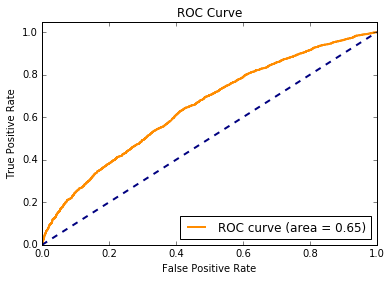

In [216]:
plot_roc(subreddit_id_binary[test_idx], y_score[:,1])

## Feature Importance

### Activity 3

**20mins** 

To understand what the model is doing, we want to see which features make the model more likely to classify a comment as a certain class. The CountVectorizer provides a list of features (using the `get_feature_names()` method) and model coefficients can be found in using the `coef_` method. For this activity, make a sorted list or dictionary of features and their importances (i.e., the corresponding coefficient value). Print the 5 most important features for classifying a comment as each of our class labels, SuicideWatch and depression. 

In [217]:
# ANSWER 
coef = mdl.coef_.ravel()

dict_feature_importances = dict( zip(features, coef) )
orddict_feature_importances = OrderedDict( 
                                sorted(dict_feature_importances.items(), key=lambda x: x[1]) )

ls_sorted_features  = list(orddict_feature_importances.keys())

num_features = 5
suicidewatch_features = ls_sorted_features[:5] #SuicideWatch
depression_features = ls_sorted_features[-5:] #depression
print('SuicideWatch: ',suicidewatch_features)
print('depression: ', depression_features)

SuicideWatch:  ['suicide', 'please', 'talked', 'suicidal', 'hospital']
depression:  ['helps', 'psychiatrist', 'depressed', 'effects', 'depression']


## Examine Confident Predictions 

We want to see which comments the model scores as highly probable to belong to either class. This step can help to look for patterns in model classification and to check for any obvious errors. The predict probability refers to the probablity of a comment belonging to the depression subreddit. Therefore, comments belonging to the SucideWatch subreddit will have a low probablity.



In [218]:
# maybe do something with this crazy indexing: this is python not C!
num_comments = 5
subreddit0_comment_idx = y_score[:,1].argsort()[:num_comments] #SuicideWatch
subreddit1_comment_idx = y_score[:,1].argsort()[-num_comments:] #depression

# convert back to the indices of the original dataset
top_comments_testing_set_idx = np.concatenate([subreddit0_comment_idx, 
                                               subreddit1_comment_idx])


In [222]:
# these are the 5 comments the model is most sure of 
for i in top_comments_testing_set_idx:
    print(
        u"""{}:{}\n---\n{}\n===""".format(test_subreddit_id[i],
                                          y_score[i,1],
                                          test_corpus[i]))

SuicideWatch:0.009617024344665628
---
It sounds like you're exhausted on many levels and are losing hope or have lost hope. I'm so sorry. 

For what it's worth, it's striking that you give equal weight in your post to your personal struggles and your existential despair at the state of the world. That's pretty remarkable - it speaks to your empathy. You are not worthless. I think that you want to help people. You say that you don't even know why you try - but it sounds like you do know. You care about the world so much that it hurts. Helping people gives life meaning, right? And sometimes jerks may deny that or try to take that from you, but we all have to fight them. 

I know that I can't imagine the added pain of being trans in a hostile world, though some of this, I get. I'm queer too and not in a good situation right now and it sounds like you've got something eating disordered type stuff going on - that certainly makes the world a harder place to live in. There is help out there t

As can be seen from the comments for the three highest probablities for SucideWatch and depression, the classifier does a good job. Note the last entry in the list of SuicideWatch top comments is miscategorized. This is most likely due to references to depression, depression medication, and psychological treatment. 

# Document Similarity and Clustering 

The first step in grouping documents is to define a measure of similarity between documents. A common measure of similarity for non-text data is euclidean distance. However the euclidean distance between document-term vectors ignore the length of the document. For example, if document one consists of a single sentence and document two consists of that same sentence repeated multiple times, the euclidean distance will be nonzero. To overcome this issue documents are often compared using cosine similarity, which measures the angle between two count vectors. 

### Cosine Similarity 

The cosine similarity between two vectors ${\bf x}$ and ${\bf y}$ is defined as: 

$$\textrm{cos}({\bf x},{\bf y}) = \frac{{\bf x} \bullet {\bf y}}{||\bf x|| \; || \bf y ||}$$. 

The common conceptual interpretations of the cosine similarity is the angle between two vectors. In text analysis each document is represented as a point in a $V$-dimensional, where $V$ is the size of the vocabulary. Thus by normalizing we are looking at the percent of a document that each word compromises instead of the raw counts of word tokens. 


Below is an example illustrating why we use cosine distance. The example computes the euclidean and cosine distances between repeated sentences. 

In [213]:
sentences = ['The girl went to the store', 
             'The girl went to the store. The girl went to the store',
             'The girl went to the store. The girl went to the store. The girl went to the store']

vectorizer_sim = CountVectorizer(analyzer=ANALYZER,
                            tokenizer=None, # alternatively tokenize_and_stem but it will be slower 
                            ngram_range=(0,1)
                            )

sentence_count = vectorizer_sim.fit_transform( sentences ) 


euclidean_distance = euclidean_distances(sentence_count, Y = None)# sentence_count, Y=None, dense_output=True, 'l2')
cosine_distance = cosine_distances(sentence_count, Y=None )

print("Euclidean Distance\n", euclidean_distance.round(2))
print("\nCosine Distance\n", cosine_distance.round(2))

Euclidean Distance
 [[ 0.    2.83  5.66]
 [ 2.83  0.    2.83]
 [ 5.66  2.83  0.  ]]

Cosine Distance
 [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -0.]]


In [182]:
num_comments = 1000
bag_of_words = vectorizer.fit_transform( processed_corpus[0:(num_comments-1)] ) 

In [194]:
#cluster = AgglomerativeClustering(n_clusters = 10, affinity="cosine", linkage ="average")
#cluster.fit(bag_of_words.toarray())
#labels = cluster.labels__

start_time = time.time()

# calculate cosine similarity and fit clustering algorithm
cosine_similarity = cosine_similarity(bag_of_words, Y=None )
labels = spectral_clustering(affinity=cosine_distance, n_clusters = 4)

print('Time Elapsed: {0:.2f}s'.format(
        time.time()-start_time))

label_counter = Counter(labels)
print(label_counter)

Time Elapsed: 6.98s


In [198]:
# examine the comments that fall in each group
# what defines each group?
for key, value in label_counter.items():
    count = 0
    print("\n-------Group{}-------\n\n".format(key))
    for i in range(0, num_comments-1):
        if (labels[i] == key) & (count < num_comments_to_view):
            print("Comment {0}: {1}\n".format(i, corpus[i]))
            #print("Comment {0}: {1}\n".format(i, processed_corpus[i]))
            count += 1
    


-------Group0-------


Comment 5: Ah. Well, sometimes just him listening can be enough. Just so long as he doesn't tell you to snap out of it or anything like that. Maybe you can also research support groups in your area. Try and find as many resources as you can.

Comment 15: I'm sure you're a very pretty young girl.  Please don't let the tauntings of small-minded people scar you.
Just endure for a little while longer.  These things improve greatly in a few years.

Comment 16: This is a reply to OP and also /u/strincheese13 and /u/elleundomiel.  

It may seem like it, but please believe me that your future is far from ruined because of a bad year or two in school.  Sure, it may make things a bit tougher in some respects, but you are far from doomed because of it. For the vast majority of careers, especially that don't require post-graduate education/certification, no one even cares what your marks are, just that you completed it.  And that's not even getting into the many careers tha

# Topic Modeling: Unsupervised Learning

In this portion of the tutorial we will be extracting topics in the form of commonly co-occuring words from the corpus of data. 

In [18]:
# Options
N_TOPICS = 50
N_TOP_WORDS = 10

## Load and Preprocess Reddit Data

In [19]:
start = time.time()
corpus_all, subreddit_id_all = load_reddit('./data/RC_2015-05.json',MIN_CHAR=250)
end = time.time()
print('Loading takes {0:2f}s'.format(end-start))

Loading takes 4.794395s


## Preprocess the data

In [20]:
# Get rid of punctuation and set to lowercase  
start = time.time()
processed_corpus_all = [ re.sub( RE_PREPROCESS, ' ', comment).lower() for comment in corpus_all]

#tokenzie the words
bag_of_words_all = vectorizer.fit_transform( processed_corpus_all ) 
end = time.time() 
#grab the features/vocabulary
features_all = vectorizer.get_feature_names()
print("Processing took {}s".format(end - start))

Processing took 29.07464623451233s


In [21]:
print(Counter(subreddit_id_all), len(subreddit_id_all))

Counter({'depression': 12079, 'offmychest': 10661, 'stopdrinking': 6958, 'SuicideWatch': 6098, 'ADHD': 5674, 'GetMotivated': 4799, 'Anxiety': 4466, 'Meditation': 3608, 'stopsmoking': 1867, 'leaves': 1629, 'BPD': 1618, 'BipolarReddit': 1515, 'OpiatesRecovery': 1391, 'socialanxiety': 1221, 'StopGaming': 946, 'schizophrenia': 898, 'mentalhealth': 572, 'ptsd': 566, 'MMFB': 483, 'alcoholism': 378, 'rapecounseling': 283, 'BipolarSOs': 272, 'AlAnon': 267, 'ZenHabits': 237, 'alcoholicsanonymous': 219, 'getting_over_it': 208, 'EatingDisorders': 203, 'Anger': 165, 'selfhelp': 150, 'StopSelfHarm': 136, 'dpdr': 105, 'survivorsofabuse': 96, 'helpmecope': 45, 'AtheistTwelveSteppers': 29, 'problemgambling': 17, 'buddhistrecovery': 12, 'MaladaptiveDreaming': 9, 'psychoticreddit': 8, 'PanicAttack': 8, 'secularsobriety': 6, 'SMARTRecovery': 5, 'secondary_survivors': 5, 'hardshipmates': 4, 'PanicParty': 4, 'afterthesilence': 3, 'feelgood': 2, 'jessiesparents': 1, 'Existential_crisis': 1}) 69927


## Fit a Topic Model

To create our topics we will use the LatentDirichletAllocation algorithm 

In [22]:
start = time.time()
lda = LatentDirichletAllocation( n_topics = N_TOPICS )
doctopic = lda.fit_transform( bag_of_words_all )
end = time.time() 
print("Processing took {}s".format(end- start)) # takes ~72s for 1 file, ~445s for 5 files

/home/akumar/py3venv/lib/python3.4/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Processing took 352.21460127830505s


## Display the top ten words for each topics 

In [36]:

ls_keywords = []
for i,topic in enumerate(lda.components_):
    word_idx = np.argsort(topic)[::-1][:N_TOP_WORDS]
    keywords = ', '.join( features_all[i] for i in word_idx)
    ls_keywords.append(keywords)
    print(i, keywords)
    

0 read, normal, dont, loved, scared, follow, books, skills, found, nearly
1 brain, adhd, issues, use, attention, also, due, cause, part, several
2 job, money, thinking, stop, hours, using, fix, spend, jobs, straight
3 keep, body, mind, practice, simple, reasons, choose, going, helps, kept
4 pretty, school, really, much, high, reading, get, think, lot, end
5 family, us, book, bring, young, wait, interested, called, together, loss
6 http, com, www, http www, reddit, message, reddit com, www reddit, comments, please
7 good, luck, best, good luck, idea, great, recovery, addiction, another, choice
8 less, living, stress, full, knowing, difference, horrible, gave, moved, order
9 gt, amp, org, drugs, words, hang, wiki, research, history, amount
10 else, alone, anyone, others, answer, perhaps, yet, question, something, big
11 thanks, control, thank, told, feels, let, steps, appreciate, inside, feels like
12 feel, better, little, make, left, today, right, lost, god, hope
13 month, eat, take, ex

## first 25 comments with the majority topic

In [37]:
num_comments = 50
for comment_id in range(num_comments):
    topic_id = np.argsort(doctopic[comment_id])[::-1][0]
    print('comment_id:',
          comment_id,
          subreddit_id_all[comment_id],
          'topic_id:',
          topic_id,
          'keywords:',
           ls_keywords[topic_id])
    print('---')
    print(corpus_all[comment_id])
    print('===')

comment_id: 0 offmychest topic_id: 14 keywords: pain, call, life, would, fucking, real, hurt, issue, suicide, gone
---
It's not your fault don't think that. Hey if this helps it does then if it doesn't well. At least I can talk about it.

I shot my dog. I had him for 10 years. I can home from partying and it was New Years so I was going to shoot off my .40 so...

Well I was loading it outside and I shot it off accidentally. Right into my dog. Me having about 5-7 tequila shots into me though if I go to sleep I would wake up and he would be okay. Well if I called a vet when I shot him I could have saved him. Or at least from his pain. So I woke up saw a dead dog in my yard… i cried for hours. That old dog still had a few good years in him. 

That was my fault and you sitting on a little tiny mouse is more understandable than a man discharging a firearm into a shitzu. Don't feel to bad. 
===
comment_id: 1 offmychest topic_id: 4 keywords: pretty, school, really, much, high, reading, get, t

Return to [TOC](#Table-of-Contents)